# Content and Objectives

- Show effects of asynchronity to IQ signal
- QPSK symbols are being pulse-shaped by RRC, distorted in the channel by phase, frequency, and noise and depicted in the complex plane

# Import

In [1]:
# importing
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib

# showing figures inline
%matplotlib inline

In [2]:
# plotting options 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)

matplotlib.rc('figure', figsize=(18, 6) )

# Function for determining the impulse response of an RRC filter

In [3]:
########################
# find impulse response of an RRC filter
########################
def get_rrc_ir(K, n_up, t_symb, r):
        
    ''' 
    Determines coefficients of an RRC filter 
    
    Formula out of: J. Huber, Trelliscodierung, Springer, 1992, S. 15
    At poles, values of wikipedia.de were used (without cross-checking)
    
    NOTE: Length of the IR has to be an odd number
    
    IN: length of IR, upsampling factor, symbol time, roll-off factor
    OUT: filter ceofficients
    '''

    assert K % 2 != 0, "Filter length needs to be odd"
    
    if r == 0:
        r = 1e-32

    # init
    rrc = np.zeros(K)
    t_sample = t_symb/n_up
    
        
    i_steps = np.arange( 0, K)
    k_steps = np.arange( -(K-1)/2.0, (K-1)/2.0 + 1 )    
    t_steps = k_steps*t_sample

    for i in i_steps:

        if t_steps[i] == 0:
            rrc[i] = 1.0/np.sqrt(t_symb) * (1.0 - r + 4.0 * r / np.pi )

        elif np.abs( t_steps[i] ) == t_symb/4.0/r:
            rrc[i] = r/np.sqrt(2.0*t_symb)*((1+2/np.pi)*np.sin(np.pi/4.0/r)+ \
                            ( 1.0 - 2.0/np.pi ) * np.cos(np.pi/4.0/r) )

        else:
            rrc[i] = 1.0/np.sqrt(t_symb)*( np.sin( np.pi*t_steps[i]/t_symb*(1-r) ) + \
                            4.0*r*t_steps[i]/t_symb * np.cos( np.pi*t_steps[i]/t_symb*(1+r) ) ) \
                            / (np.pi*t_steps[i]/t_symb*(1.0-(4.0*r*t_steps[i]/t_symb)**2.0))
 
    return rrc

# Parameters

In [4]:
# characterize Eb/N0 if you like to
EbN0_dB = 100

In [5]:
# modulation scheme and constellation points
constellation = [ 1 + 1j, -1 + 1j, -1 - 1j, 1 - 1j ]
constellation /= np.sqrt(2)

M = len( constellation )

# number of symbols    
n_symb = 100
t_symb = 1.0 


# get according noise variance
# NOTE: Since non-binary symbols are used normalization log2(M) has to be applied
sigma2 = 1 / ( np.log2(M) * 10**( EbN0_dB / 10 ) )


# parameters for rrc
beta = 0.33

# oversampling factor; samples per symbol
n_up = 8           

# symbols per filter (plus minus in both directions)
syms_per_filt = 10  

# length of the fir filter
K_filt = 2*syms_per_filt*n_up+1         

# get rrc impulse response
rrc = get_rrc_ir(n_up*syms_per_filt*2+1, n_up, t_symb, beta)
rrc /= np.linalg.norm( rrc )


# Generating Tx Signal


Determine Tx signal by upsampling and rrc filtering.

In [6]:
# generate random binary vector and modulate the specified modulation scheme
data = np.random.randint( M, size=n_symb )
s = [ constellation[ d ] for d in data ]


# prepare sequence to be filtered
s_up = np.zeros( n_symb * n_up, dtype=complex )        
s_up[::n_up] = s
s_up = np.append( s_up, np.zeros( K_filt - 1 ) )        

s_Tx = np.convolve( rrc, s_up )

# Adding Distortions

In [7]:
# vector of time samples
t_vec = np.arange(0, np.size( s_Tx ) * t_symb / n_up, t_symb / n_up)

# determine noise (using the same for all scenarios)
n = np.sqrt( sigma2 / 2 ) * (np.random.randn( len( t_vec ) ) + 1j*np.random.randn( len( t_vec ) ) )

# initialize dict for different signals
r = {}

# Rx signal 1:
# noise only
delta_phi = 0
delta_f = 0

s_Rx = s_Tx * np.exp( 1j * delta_phi ) * np.exp( 1j * 2 * np.pi * delta_f * t_vec )
r[ 'Noise only' ] = s_Rx + n


# Rx signal 2:
# phase distortion only
delta_phi = np.pi/8 
delta_f = 0

s_Rx = s_Tx * np.exp( 1j * delta_phi ) * np.exp( 1j * 2 * np.pi * delta_f * t_vec )
r[ 'Phase Distortion plus Noise' ] = s_Rx + n


# Rx signal 3:
# phase and frequency distortion
delta_phi = np.pi/8 
delta_f = 1 / ( 1e3 * t_symb / n_up )

s_Rx = s_Tx * np.exp( 1j * delta_phi ) * np.exp( 1j * 2 * np.pi * delta_f * t_vec )
r[ 'Phase and Frequency Distortion plus Noise' ] = s_Rx + n


# find signal after MF
y_mf = {}
for scenario in r:
    y_mf[ scenario ] = np.convolve( rrc, r[ scenario ] )

# down-sampling
y_down = {}
for scenario in y_mf:
    y_down[ scenario ] = y_mf[ scenario ][ K_filt-1 : K_filt-1 + len(s)*n_up : n_up ]



# Plotting Resulting Signals at Tx, after MF and after Sampling

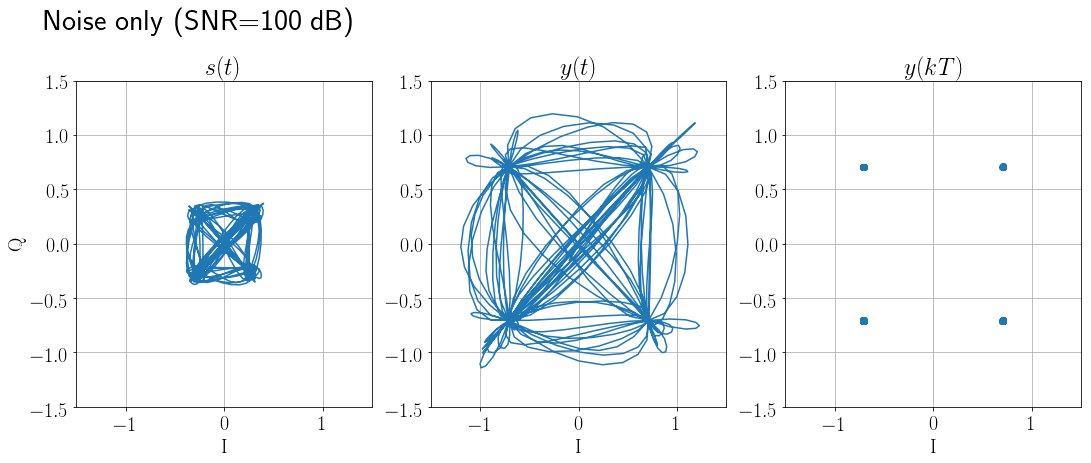

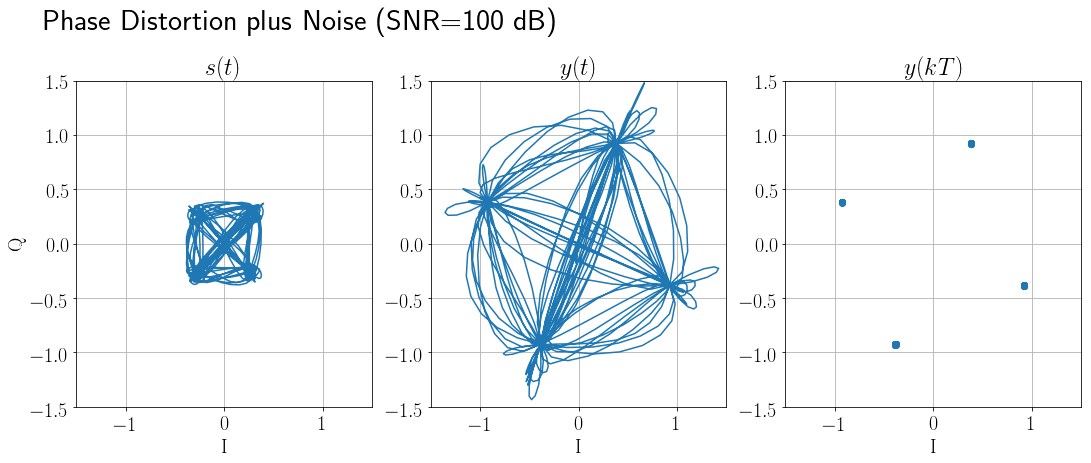

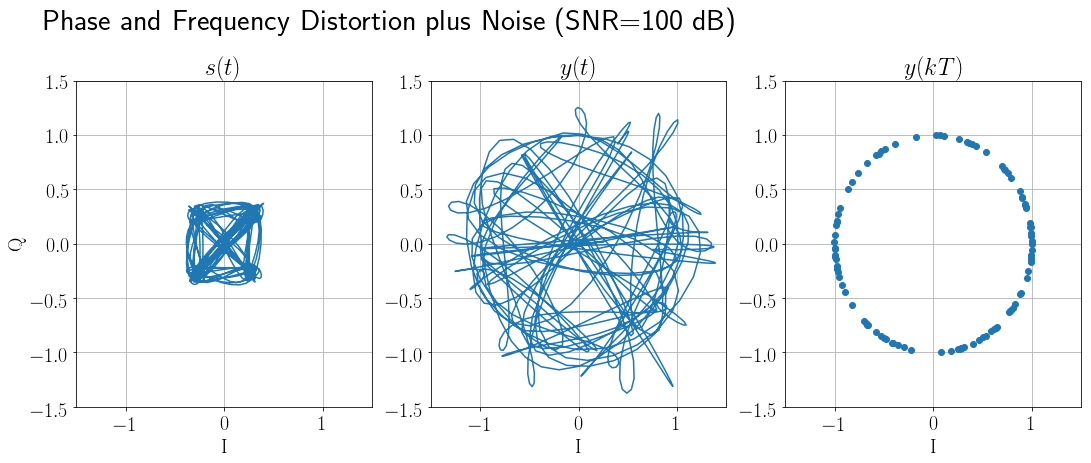

In [8]:
# Plotting
for scenario in r:  

    fig = plt.figure()

    fig.text(0.1,1, scenario + ' (SNR={} dB)'.format(EbN0_dB), size='30')
    
    plt.subplot(131)  
    plt.plot( np.real(s_Tx), np.imag(s_Tx))
    plt.grid(True); plt.xlabel('$\\mathrm{I}$');  plt.ylabel('$\\mathrm{Q}$')
    plt.title('$s(t)$')
    plt.xlim( (-1.5, 1.5) )
    plt.ylim( (-1.5, 1.5) )

    plt.subplot(132)  
    plt.plot( np.real(y_mf[ scenario ] ), np.imag(y_mf[ scenario ]))
    plt.grid(True); plt.xlabel('$\\mathrm{I}$');  
    plt.title('$y(t)$')
    plt.xlim( (-1.5, 1.5) )
    plt.ylim( (-1.5, 1.5) )


    plt.subplot(133)  
    plt.plot( np.real(y_down[ scenario ]), np.imag(y_down[ scenario ]),'o')
    plt.grid(True); plt.xlabel('$\\mathrm{I}$');  
    plt.title('$y(kT)$')
    plt.xlim( (-1.5, 1.5) )
    plt.ylim( (-1.5, 1.5) )